# Experiments with WCDS
This notebook contains all experiments that are done using WCDS.

In [1]:
%matplotlib inline 
#%matplotlib notebook
import matplotlib.pyplot as plt
from wcds.wcds import WCDS
from wcds.clusterers import AgglomerativeClustering
import time
from sklearn.datasets import *
from sklearn.preprocessing import minmax_scale
import pandas as pd
import numpy as np
import random
import math

## Datasets
In the following sections `datastream` will be the variable storing the current datastream. By executing one of the following cells, the chosen dataset/-stream will be loaded.

In [30]:
# Complex8
url = "http://www2.cs.uh.edu/~ml_kdd/restored/Complex&Diamond/Complex8.data"
data = pd.read_csv(url)
x = minmax_scale(list(data["563.225"]))
y = minmax_scale(list(data["56.748"]))
data = list(zip(x,y))
#np.random.shuffle(data) # Shuffling datastream
datastream = list(zip(data, list(range(len(data)))))

In [ ]:
# Network Intrusion Detection (kddcup 1999)
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
# TODO

In [ ]:
# Forest Cover Type
# TODO

## Online clustering
The next steps is to perform the online step of stream clustering with wcds.

In [31]:
%%time

# Parameters
OMEGA = 3000
DELTA = 200
GAMMA = 500
EPSILON = 0.8
µ = 1

c_online = WCDS(
    omega=OMEGA,
    delta=DELTA,
    gamma=GAMMA,
    epsilon=EPSILON,
    dimension=len(datastream[0][0]),
    µ=µ)

assigned_discriminators = []
for i in datastream:
    obs, time_ = i
    k = c_online.record(obs, time_)
    assigned_discriminators.append(k)

Wall time: 51.6 s


In [ ]:
# Optional save
clusterer.save("wcds.json")

## Offline clustering
Now we perform offline clustering on wcds current configuration.

In [32]:
%%time

c_offline = AgglomerativeClustering()
actual_clusters = c_offline.fit(c_online.discriminators, n_clusters=8)

Wall time: 10.7 s


## Plot results

In [33]:
# Initialize color list
number_of_colors = max(assigned_discriminators)+1
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
color_dict = {key: value for (key, value) in enumerate(colors)}

Found 202 Microclusters and formed 8 Clusters.


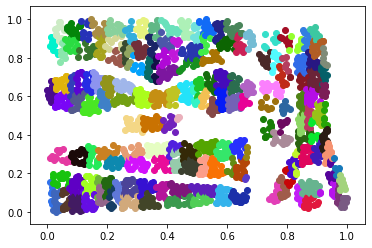

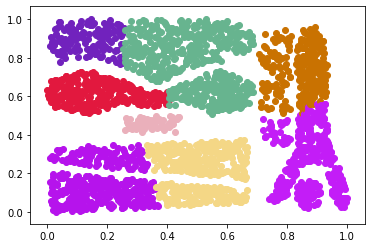

In [34]:
# Plot results of online vs offline clustering
%matplotlib inline

# Online
plt.figure(1)
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    plt.scatter(datastream[i][0][0], datastream[i][0][1], marker="o", color=color_dict[int(k)])

# Offline
plt.figure(2)
def return_correct(index, clustering):
    for i in range(len(clustering)):
        if index in clustering[i]:
            return i
        
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    correct = return_correct(k, actual_clusters)
    plt.scatter(datastream[i][0][0], datastream[i][0][1], marker="o", color=color_dict[correct])
    
print("Found {} Microclusters and formed {} Clusters.".format(max(predictions)+1, len(actual_clusters)))
plt.show()

<IPython.core.display.Javascript object>


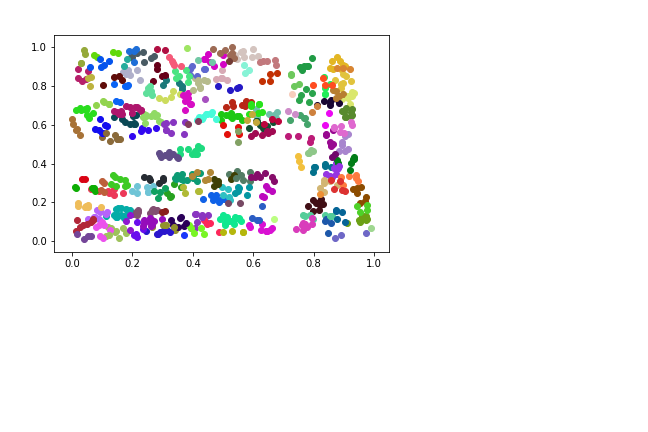

KeyboardInterrupt: 

In [14]:
# Live online clustering plot
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    ax.scatter(datastream[i][0][0], datastream[i][0][1], marker="o", color=color_dict[int(k)])
    fig.canvas.draw()
    #time.sleep(.01)

In [27]:
# Show discriminator bubble
%matplotlib inline

def plot_discriminator(c_id, step=0.01):
    points = []

    for i in np.arange(0,1,step):
        for j in np.arange(0,1,step):
            if c_online.discriminators[c_id].matching(c_online.addressing((i,j))) > c_online.epsilon:
                points.append((i,j))
    plt.scatter([point[0] for point in points], [point[1] for point in points], marker="s", s=1, color=color_dict[c_id])
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.show()

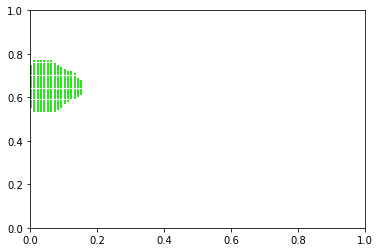

In [29]:
plot_discriminator(8)